In [1]:
#Include Libraries:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
#Read CSV Files
dataset_dir = "./Dataset/"
chotot_dataset = pd.read_csv(dataset_dir + "chotot.csv",index_col = [0])
phongtro123_dataset = pd.read_csv(dataset_dir + "phongtro123.csv",index_col=[0])
print(phongtro123_dataset.head())
print(chotot_dataset.head())

       Price  Area            Ward     District
0  1300000.0    20        Hòa Minh   Liên Chiểu
1  3000000.0    25   Nại Hiên Đông      Sơn Trà
2  1500000.0    15         Hòa Khê    Thanh Khê
3  2600000.0    30      An Hải Bắc      Sơn Trà
4  3200000.0    40   Hòa Khánh Nam   Liên Chiểu
     Price  Area  Deposit Fee        Furniture           Ward     District
0  1600000    20     500000.0              NaN   Hòa Thọ Đông       Cẩm Lệ
1  1100000    40      50000.0  Nội thất đầy đủ    Thuận Phước     Hải Châu
2  1500000    20     500000.0        Nhà trống       Hòa Phát       Cẩm Lệ
3  2500000    25    2500000.0  Nội thất đầy đủ       Hòa Minh   Liên Chiểu
4  1200000    30    1000000.0  Nội thất đầy đủ    Thuận Phước     Hải Châu


In [3]:
#Preparing Dataset for Feature Engineering
chotot_dataset = chotot_dataset.drop(columns=['Furniture','Deposit Fee'])
Dataset = pd.concat([chotot_dataset, phongtro123_dataset])
print(Dataset.shape)
Dataset.head()

(1654, 4)


,Price,Area,Ward,District
0,1600000.0,20,Hòa Thọ Đông,Cẩm Lệ
1,1100000.0,40,Thuận Phước,Hải Châu
2,1500000.0,20,Hòa Phát,Cẩm Lệ
3,2500000.0,25,Hòa Minh,Liên Chiểu
4,1200000.0,30,Thuận Phước,Hải Châu


In [4]:
#Checking Nan values in Dataset
Dataset.isna().sum()

Price        20
Area          0
Ward        103
District     36
dtype: int64

In [5]:
#Splitting Continous and Categorical columns
Categorical_cols = ['Ward','District']
Continous_cols = ['Area']

In [6]:
#Filling Nan values in these feature columns
Dataset['Price'].fillna(value = Dataset['Price'].mean(), inplace = True)
Dataset['Ward'].fillna(value = 'Unknown', inplace= True)
Dataset['District'].fillna(value = 'Unknown', inplace = True)

In [7]:
#Onehot Encoding for Categorical Columns
ohe = OneHotEncoder(sparse=False)
ohe_set = ohe.fit_transform(Dataset[Categorical_cols])
ohe_name_col = []
for i in ohe.categories_:
    ohe_name_col+=(i.tolist())

In [8]:
#Standard Scaler for Continous Columns
std = StandardScaler()
std_set = std.fit_transform(Dataset[Continous_cols])

In [9]:
#Concat all dataframe which we created recently:
Train_set = pd.concat([pd.DataFrame(data=ohe_set,columns=ohe_name_col), pd.DataFrame(data = std_set, columns = Continous_cols)], axis = 1)
Train_set = Train_set.drop(columns = 'Unknown')
Train_set.head()

,An Hải Bắc,An Hải Tây,An Hải Đông,An Khê,Bình Hiên,Bình Thuận,Chính Gián,Hoà Hải,Hoà Quý,Hòa An,...,Xuân Hà,Cẩm Lệ,Hoà Vang,Hòa Vang,Hải Châu,Liên Chiểu,Ngũ Hành Sơn,Sơn Trà,Thanh Khê,Area
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030783
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.029189
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.030783
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.030384
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.029986


In [10]:
Target_std = StandardScaler().fit(Dataset[['Price']])
Target_set = pd.DataFrame(data = Target_std.transform(Dataset[['Price']]), columns = ['Price'])
Target_set.head()

,Price
0,-0.033574
1,-0.042050
2,-0.035269
3,-0.018317
4,-0.040354


In [11]:
#Removing Outlier Values from Dataset
for x in Target_set:
    q75,q25 = np.percentile(Target_set.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    Target_set.loc[Target_set[x] < min,x] = np.nan
    Target_set.loc[Target_set[x] > max,x] = np.nan
Target_set.isna().sum()
Target_set.fillna(value = Target_set.mean(), inplace = True)


for x in Train_set:
    q75,q25 = np.percentile(Train_set.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    Train_set.loc[Train_set[x] < min,x] = np.nan
    Train_set.loc[Train_set[x] > max,x] = np.nan
Train_set.isna().sum()
Train_set.fillna(value = Train_set.mean(), inplace = True)

# Predict

In [12]:
#Include Libraries:
from sklearn.linear_model import ridge_regression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(Train_set, Target_set, random_state=43, shuffle=True,test_size = 0.2)

In [14]:
def Get_Score(algo, name):
    algo.fit(x_train,y_train)
    y_pred = algo.predict(x_test)
    x_ax = range(len(y_pred))
    original_set = Target_std.inverse_transform(y_test)
    predicted_set = Target_std.inverse_transform(y_pred)
    plt.scatter(x_ax, original_set, s = 5, color="blue", label="original")
    plt.plot(x_ax, predicted_set, color="red", label="predicted")
    plt.legend()
    plt.show()
    score = mean_squared_error(y_test,y_pred)
    print(name,'Mean squared error: ',score)
    return predicted_set, original_set

/var/folders/2r/vgdn5c2j5fb567xb2nm5_qfm0000gn/T/ipykernel_96620/3880687256.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  algo.fit(x_train,y_train)


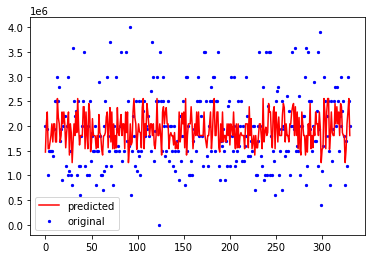

RandomForest Mean squared error:  0.00013188262715723342


In [15]:
RF = RandomForestRegressor(n_estimators=2000,
                            max_depth=7,
                            max_features='auto',
                            verbose=0,
                            random_state=30,
                            min_samples_leaf=6,
                            oob_score=True,
                            min_samples_split=4)
predicted_set, original_set = Get_Score(RF, 'RandomForest')

# Result

In [16]:
predicted_set = pd.DataFrame(data = np.ravel(predicted_set))
original_set = pd.DataFrame(data = np.ravel(original_set))
Result_set = pd.concat([predicted_set,original_set], axis = 1)
Result_set.to_csv('Result.csv')